# Clasificación con Regresión logística. Modelos discriminativos

La clase pasada presentamos el perceptrón, y vimos cómo este algoritmo encontraba una frontera de decisión adecuada para conjuntos linealmente separables a partir de la disminución de una función de error particular (llamada **función de error del peceptrón**).

Las tres particularidades a retener del perceptrón son:

1. La función de error es cero para cualquier frontera de decisión que separe a los conjuntos perfectamente.
2. La clasificación se hace usando el signo de la función de decisión (es decir, la función de activación es una función escalón).
3. Para conjuntos linealmente separables, hay garantía de que el algoritmo de minimización encontrará una frontera de decisión que conduce a una clasificación sin errores.

Hoy vamos a ver otro algoritmo de clasificación: la **regresión logística**. 

En este caso, se busca que el algoritmo devuelva una **probabilidad de pertencer a una de las clases**, y una clasificación directamente. Los algoritmos que hacen esto, se conocen como **modelos discriminativos**. El hecho de tener una probabilidad habilita a tomar una serie de decisiones que nos son posibles con los modelos tipo perceptrón (**funciones discriminativas**) o a hacerlo con una rigurosidad teórica mucho mayor.

### Funciones útiles

Para arrancar volvamos a definir algunas funciones útiles para graficar fronteras y funciones de decisión en dos dimensiones y para obtener el vector de los pesos del modelo lineal.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_clasi(x, t, ws, labels=[], xp=[-1,1], spines='zero',
               equal=True, join_centers=False, margin=None, **kwargs):
    """
    Plot results of linear classification problems.
    :param np.array x: Data matrix
    :param np.array t: Label vector.
    :param list or tuple ws: list with fitted paramter vector of models, one element per model
    :param tuple xp: start and end x-coordinates of decision boundaries and
                     margins.
    :param str or None spines: whether the spines go through zero. If None,
                               the default behaviour is used.
    :param bool equal: whether to use equal axis aspect (default=True;
                       recomended to see the parameter vector normal to
                       boundary)
    :param bool join_centers: whether to draw lines between classes centres.
    :param None or tuple margin: tupler of booleans that define whether
                                 to plot margin for each model being plotted.
                                 If None, False for all models.
    """
    assert len(labels) == len(ws) or len(labels) == 0

    if margin is None:
        margin = [False] * len(ws)
    else:
        margin = np.atleast_1d(margin)
    assert len(margin) == len(ws)
    
    if len(labels) == 0:
        labels = np.arange(len(ws)).astype('str')

    # Agregemos el vector al plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111)

    xc1 = x[t == np.unique(t).max()]
    xc2 = x[t == np.unique(t).min()]

    ax.plot(*xc1.T, 'or', mfc='None', label='C1')
    ax.plot(*xc2.T, 'ob', mfc='None', label='C2')

    for i, w in enumerate(ws):
        # Separa el sesgo del resto de los pesos
        thr = -w[0]
        w = w[1:]
        # Calcula la norma del vector
        wnorm = np.sqrt(np.sum(w**2))

        # Ploteo vector de pesos
        ax.quiver(0, thr/w[1], w[0]/wnorm, w[1]/wnorm,
                  color='C{}'.format(i+2), scale=10, label=labels[i],
                  zorder=10)

        # ploteo plano perpendicular
        xp = np.array(xp)
        yp = (thr - w[0]*xp)/w[1]

        plt.plot(xp, yp, '-', color='C{}'.format(i+2))

        # ploteo el margen (para SVC)
        if margin[i]:
            for marg in [-1, 1]:
                ym = yp + marg/w[1]
                plt.plot(xp, ym, ':', color='C{}'.format(i+2))

    if join_centers:
        # Ploteo línea que une centros de los conjuntos
        mu1 = xc1.mean(axis=1)
        mu2 = xc2.mean(axis=1)
        ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)

    ax.legend(loc=0, fontsize=12)
    if equal:
        ax.set_aspect('equal')

    if spines is not None:
        for a in ['left', 'bottom']:
            ax.spines[a].set_position('zero')
        for a in ['top', 'right']:
            ax.spines[a].set_visible(False)

    for k in kwargs:
        print(k, kwargs[k])
        getattr(ax, 'set_'+k)(kwargs[k])
        
    return


def makew(fitter, norm=False):
    """
    Prepare parameter vector for an sklearn.liner_model predictor.
    
    :param sklearn.LinearModel fitter: the model used to classify the data
    :param bool norm: default: False; whether to normalize the parameter vector
    """
    # # Obtengamos los pesos
    w = fitter.coef_.copy()

    # # Incluye intercept
    if fitter.fit_intercept:
        w = np.hstack([fitter.intercept_.reshape(1, 1), w])

    # # Normalizon
    if norm:
        w /= np.linalg.norm(w)
    return w.T


def plot_fundec(fitter, x, t):

    plt.figure(figsize=(9, 7))

    xx, yy = np.meshgrid(np.linspace(x[:, 0].min()-1, x[:, 0].max()+1, 200), 
                            np.linspace(x[:, 1].min()-1, x[:, 1].max()+1, 200))

    # evaluate decision function
    try:
        Z = fitter.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        vcenter = 0.5
        name = 'Probabilidad'
    except NameError:
        Z = fitter.decision_function(np.c_[xx.ravel(), yy.ravel()])
        vcenter = 0.0
        name = 'Función de decisión'
    Z = Z.reshape(xx.shape)

    # veamos la función de decisión y la frontera de decisión
    mynorm = colors.TwoSlopeNorm(vmin=Z.min(), vmax=Z.max(), vcenter=vcenter)
    pme = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu_r, norm=mynorm, shading='auto')
    plt.colorbar(label= name)
    
    plt.contour(xx, yy, Z, [vcenter,], colors='0.5', zorder=1)
    if name == 'Probabilidad':
        plt.contour(xx, yy, Z, [vcenter - 0.45, vcenter + 0.45], 
                    colors='white', linestyles='dashed', zorder=1)

    xc1 = x[t == np.unique(t.flatten()).max()]
    xc2 = x[t == np.unique(t.flatten()).min()]

    plt.plot(*xc1.T, 'or', mfc='None', label='C1')
    plt.plot(*xc2.T, 'ob', mfc='None', label='C2')

    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

    return pme

## Datos y repaso perceptrón

Volvamos a bajar los datos de Old Faithful y recordemos cómo se veían.

In [35]:
import os

# Bajamos los datos, preparados para la ocasión
DOWNLOAD_URL = "https://github.com/IAI-UNSAM/datasets/raw/master/"
FAITH_URL = DOWNLOAD_URL + "faithful/faithful1.csv"

FAITH_PATH = './datasets'
!mkdir -p ./datasets

def bajar_fathful_data(save_path=FAITH_PATH):
    os.makedirs(save_path, exist_ok=True)
    !wget {FAITH_URL} -P {save_path}

# Corramos la función
# bajar_fathful_data()

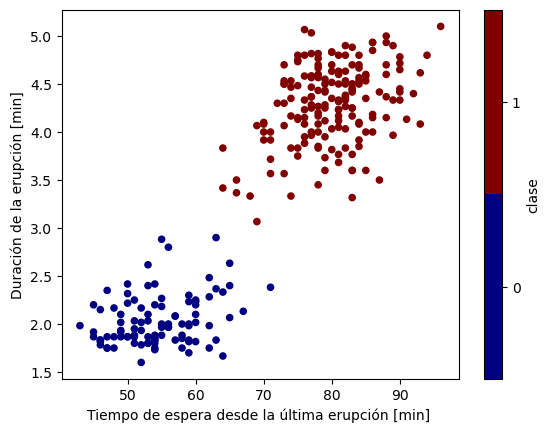

In [46]:
import pandas as pd

# Leemos los datos que recién bajamos
df = pd.read_csv(os.path.join(FAITH_PATH, 'faithful1.csv'))

# Plot del dataset
df.loc[:, 'clase'] = pd.Categorical(df.clase)

def plot_data(df):
    _ = df.plot.scatter(x='espera', y='durac_erup', c='clase',
                        xlabel='Tiempo de espera desde la última erupción [min] ',
                        ylabel='Duración de la erupción [min]',
                        cmap='jet')
    return

plot_data(df)

Preparemos el conjunto de datos igual que lo hicimos la clase pasada.

In [5]:
# Preparo la data en formato que entienda el bicho

# Separo el target
clase = df.clase.to_numpy()

# Tiro el target de la data
datos = df.drop(['clase'], axis=1, inplace=False)
# Reordeno los datos
datos = datos[['espera', 'durac_erup']]

# Los normalizo, porque los valores son grandes
from sklearn.preprocessing import StandardScaler
stsc = StandardScaler()
datosn = stsc.fit_transform(datos)

Recordemos la variedad de soluciones que podía darnos el perceptrón, dependiendo del punto de inicialización del algoritmo.

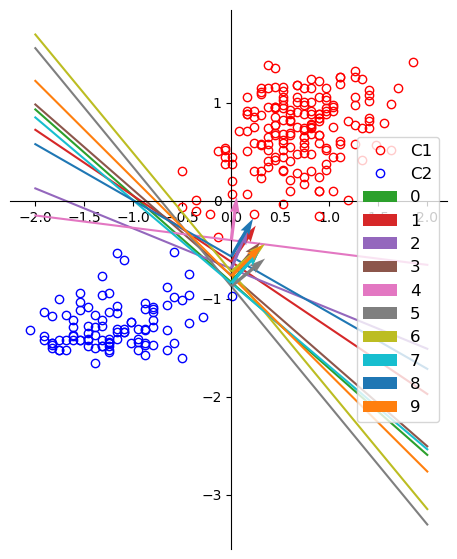

In [6]:
from sklearn.linear_model import Perceptron
perce = Perceptron()

w0s = np.random.rand(10, 2) * 5.0
intercepts = np.random.rand(10) * 5.0

wlist = []
thlist = []
for i in range(len(w0s)):
    perce.fit(datosn, clase, coef_init=w0s[i], intercept_init=intercepts[i])
    w_p = makew(perce)
    wlist.append(w_p)

plot_clasi(datosn, clase, wlist, xp=[-2, 2])

## Regresión Logística

En el acercamiento discriminativo a la clasificación, lo que obtenemos a partir de los modelos es la probabilidad de que una dada instancia pertenezca a una clase, condicionada a los valores de las características de esa instancia (es decir, la distribución posterior): $p(C_k | \boldsymbol{x})$.

Luego, uno debe definir un umbral de probabilidad por encima del cual la instancia es clasificada en esa clase.


En particular, el regresor logístico usa la función sigmoide, $\sigma(a)$ como función de activación:

$$\sigma(a) = \frac{1}{1 + \exp(-a)}\;\;,$$

donde la activación $a = f(\boldsymbol{x})$, es una función del vector de características.

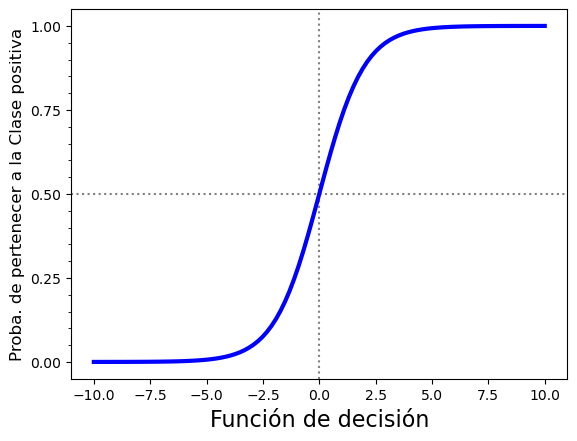

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Vector para el gráfico
x = np.linspace(-10, 10, 100)

# Función escalón, también conocida como tita de Heavyside
y = sigmoid(x)

plt.axhline(0.5, ls=':', color='0.5')
plt.axvline(0.0, ls=':', color='0.5')
plt.plot(x, y, lw=3, color='b')

plt.xlabel('Función de decisión', size=16)
plt.ylabel('Proba. de pertenecer a la Clase positiva', size=12)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.25))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))


Como en el caso del perceptrón, consideramos modelos lineales para la activación:

$$a(\boldsymbol{x}) = \omega_0 + \omega_1 x_1 + \ldots + \omega_D x_D\;\;.$$

### Función de error

La función de error para el regresor logístico está basada en la teoría de la probabilidad, exactamente igual que el MSE está justificado para los modelos de regresión. 

En este caso, la función de error es la *entropía cruzada*:

$$E = - \sum_{i=1}^N t_i \ln(y_i) + (1 - t_i) \ln(1 - y_i)\;\;,$$

donde $t_i$ es el valor de la etiqueta para la instancia $i$, con $t_i \in \{0; 1\}$, e $y_i$ es la predicción que hace el modelo para este mismo punto, y es la probabilidad de que la instancia pertenezca a la clase postiva. Es decir, $y_i \in [0, 1]$.

<!-- $$y_i = \sigma(\boldsymbol{\omega}^T \boldsymbol{\phi}(\boldsymbol{x})) = p(C_1 |\boldsymbol{x})\;\;,$$ -->

Para minimizar esta función, podemos calcular el gradiente con respecto a $\boldsymbol{\omega}$ para actualizar los valores de los parámetros de forma iterativa (es decir, hacer descenso por gradiente). Pero en este caso es mucho más eficiente usar el método de Newton-Raphson, que produce el algoritmo de **cuadrados mínimos ponderados iterativamente** (**Iteratively Reweighed Least Squares, IRLS**).

En todo caso, una ventaja enorme de este problema es que podemos demostrar matemáticamente que **la función de error tiene un solo mínimo**.

## Caso linealmente separable

Vamos a trabajar con la implementación del regresor logístico que hay en `sklearn` en un caso linealmente separable.

Antes que nada, importemos la clase del paquete `linear_model` y veamos la documentación.

In [ ]:
from sklearn.linear_model import LogisticRegression

LogisticRegression?

El regresor logístico permite un término de penalización, como para la regresión Ridge y Lasso. Veamos por qué. Empecemos en un caso sin regularización: `penalty = 'none'`.

[[64.12633453]
 [66.22919558]
 [91.00492108]]


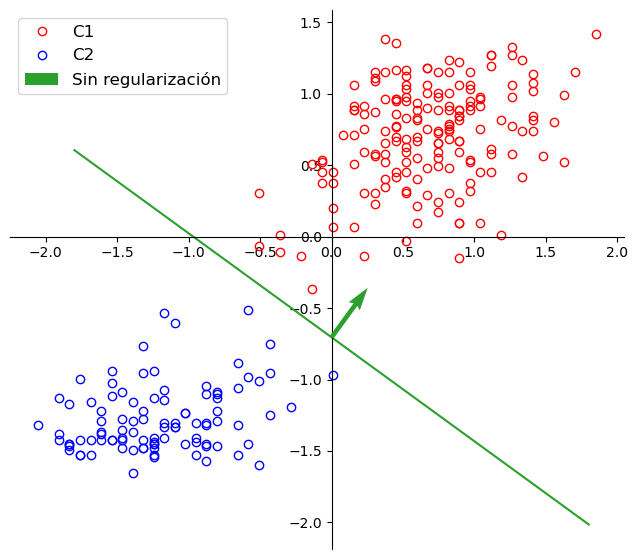

In [9]:
# Instanciamos un regresor logístico
lr = LogisticRegression(tol=1e-10, penalty='none')

# Ajustamos
lr.fit(datosn, clase)

# Construimos el vector de pesos
w_lr = makew(lr)
print(w_lr)

# Hacemos una gráfica 
plot_clasi(datosn, clase, ws=[w_lr,], labels=['Sin regularización'], xp=[-1.8, 1.8])

Con el algoritmo entrenado, calculemos la función de decisión: $a(\boldsymbol{x}) = \boldsymbol{\omega}^T \boldsymbol{\phi}(\boldsymbol{x})$, y la predicción del modelo, $\sigma(a)$.

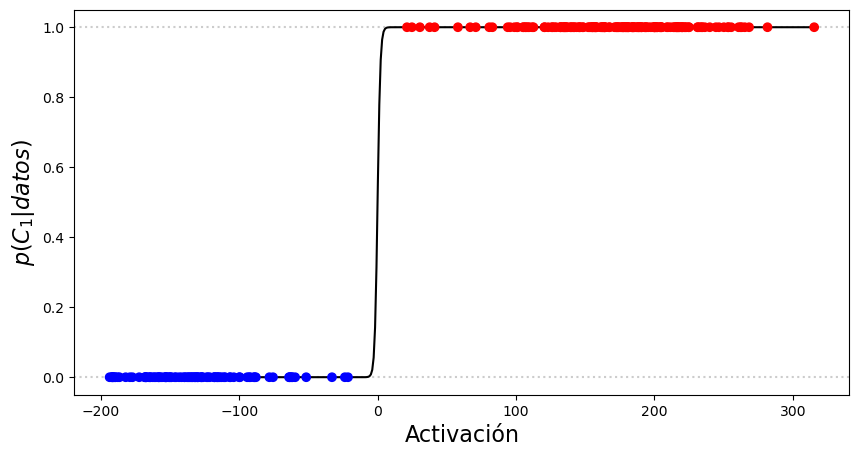

In [10]:
def plot_proba(lr, x, t):

    # La función de decisión es w.T @ phi (calculado para cada punto)
    a = lr.decision_function(x)

    # Pueden verificar que esto es idéntico a lo que tenemos arriba.
    # a = lr.intercept_ + lr.coef_[0][0] * x[:, 0] + lr.coef_[0][1] * x[:, 1]

    # Calculamos la probabilidad
    proba = sigmoid(a)

    # Ahora generamos un vector sobremuestreado entre el máximo 
    # y el mínimo de la activación, para graficar
    aa = np.linspace(a.min(), a.max(), 500)

    # Instanciamos una nueva figura
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Usamos puntos azules y rojos para la clase positiva y negativa, respectivamente
    color = np.where(t, 'r', 'b')

    # Graficamos los datos
    ax.scatter(a, proba, c=color)

    # Probabilidad en el vector sobre-muestreado
    ax.plot(aa, sigmoid(aa), '-k', zorder=-1)

    # Etiquetas y líneas horizontales en 0 y en 1
    ax.set_xlabel('Activación', fontsize=16)
    ax.set_ylabel('$p(C_1 | datos)$', fontsize=16)

    ax.axhline(0, ls=':', color='0.8', zorder=-2)
    ax.axhline(1, ls=':', color='0.8', zorder=-2)
    
    return ax

ax = plot_proba(lr, datosn, clase)

**Preguntas**

* Describan lo que muestra la figura.
* ¿Creen que el algoritmo está funcionando correctamente? ¿Por qué?
* ¿Cómo reaccionaría el algoritmo si tuviéramos puntos más cerca de la frontera de decisión?
* ¿Pueden fijar un umbral que garantice que no tendremos falsos positivos, incluso para datos no vistos anterioremente?

El problema acá es que los puntos tienen **todos aproximadamente la misma probabilidad: cero o uno**. El algoritmo está sobreajustando en el sentido de que un pequeño cambio en los datos produciría un cambio en la frontera de decisión.

Además, observen el valor de los parámetros, y de la activación. Son grandes con respecto a las dimensiones de las features. Esto recuerda lo que pasaba con los coeficientes de la regresión polinomial cuando comenzaba el sobreajuste.

Podemos convencernos de que esto es una mala idea con un gráfico de la probabilidad de la clase positiva.

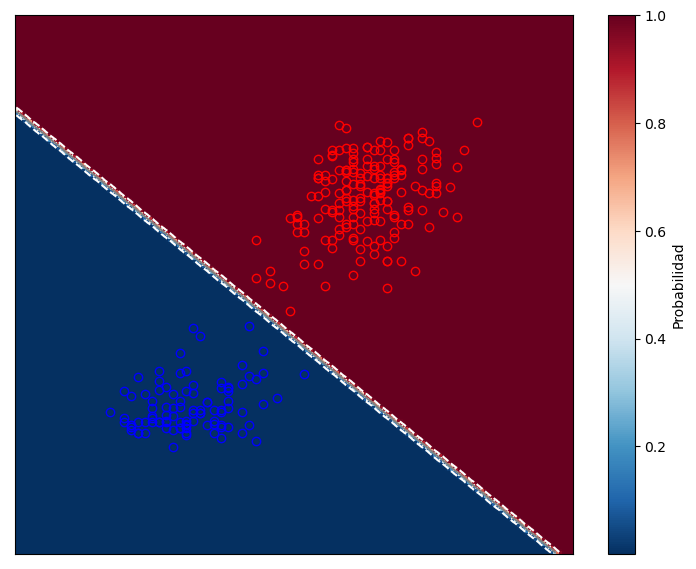

In [36]:
plot_fundec(lr, datosn, clase)

En pocas palabras, **¡convertimos a la regresión logística en un perceptrón!**

Debido a esto, el regresor logístico se usa habitualmente con un término de regularización. Se usa el hiperparámetro `C` que es la inversa del parámetro de regularización: $C = 1/\alpha$. En este caso, cuanto más chico es $C$, mayor la regularización.

Prueben distintos valores de $C$ en la celda a continuación y vean cómo cambia el valor de los parámetros y el gráfico de la probabilidad en función de la activación.

In [26]:
lr_regu = LogisticRegression(tol=1e-10, penalty='l2', C=1.0)
lr_regu.fit(datosn, clase)

print('Parámetros: {}'.format(np.concatenate([lr_regu.intercept_, lr_regu.coef_[0]])))

Parámetros: [2.07372834 2.07160474 3.11147295]


<AxesSubplot:xlabel='Activación', ylabel='$p(C_1 | datos)$'>

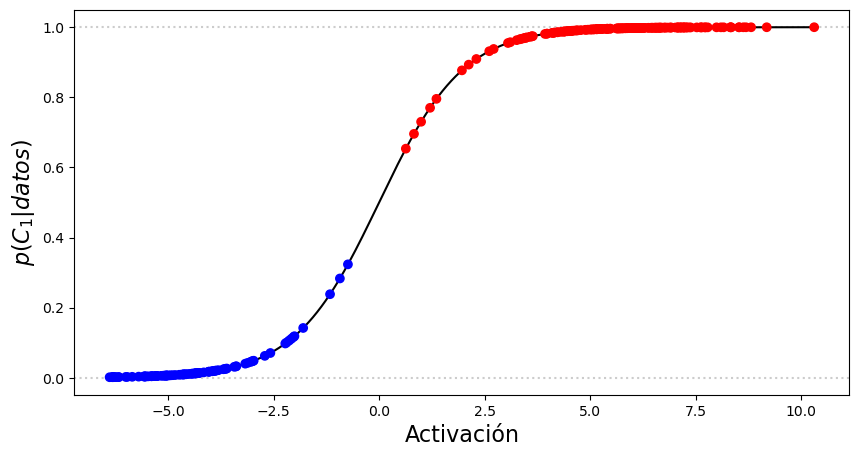

In [27]:
plot_proba(lr_regu, datosn, clase)

Veamos cómo cambia la frontera de decisión.

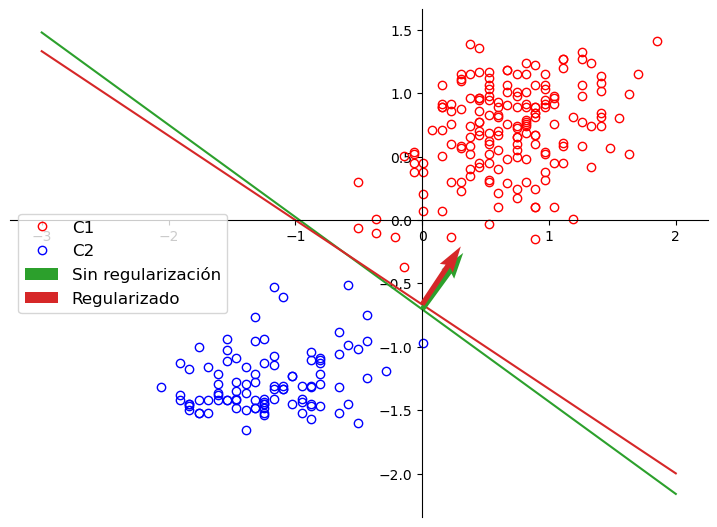

In [28]:
w_lr_regu = makew(lr_regu)
plot_clasi(datosn, clase, ws=[w_lr, w_lr_regu], xp=[-3, 2], labels=['Sin regularización', 'Regularizado'])

Vemos que no hay un gran cambio, sin embargo, sí cambia la certeza que el algoritmo asigna a sus decisiones. Eso puede verse usando la función `plot_regions`, que muestra en escala de colores la probabilidad en cada punto del espacio de los features.

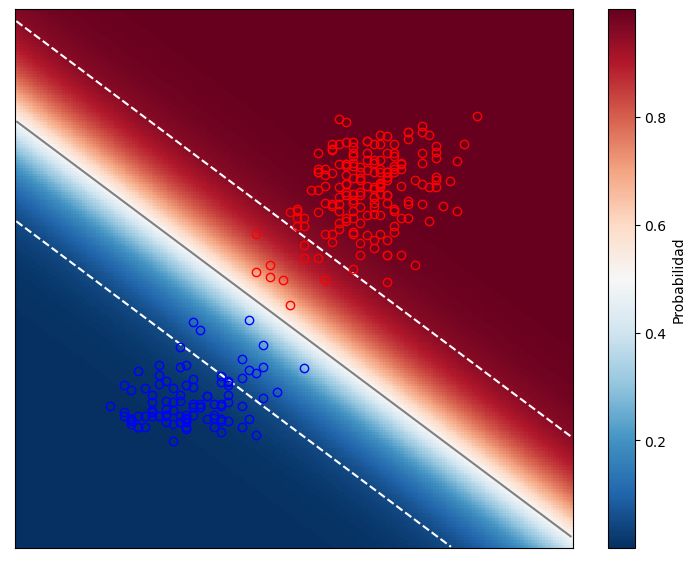

In [37]:
plot_fundec(lr_regu, datosn, clase)

La línea gruesa representa el lugar donde la probabilidad es 0.5 (podríamos llamarlo la frontera de decisión, pero en relidad no es necesariamente ahí que vamos a hacer la distinción); las líneas grises son los lugares donde la probabilidad es 0.05 (5%) y 0.95 (95%). 

Vayan para atrás, cambien el valor de $C$ y vean cómo cambia este gráfico.

Noten que en cualquier caso alcanzamos una exactitud de 100%

In [38]:
from sklearn import metrics
print('Exactitud en la RL no regularizada:', metrics.accuracy_score(clase, lr.predict(datosn)))
print('Exactitud en la RL regularizada:', metrics.accuracy_score(clase, lr_regu.predict(datosn)))

Exactitud en la RL no regularizada: 1.0
Exactitud en la RL regularizada: 1.0


Sin embargo, la función de error es más chica en el caso del algoritmo no regularizado.

In [39]:
print('Función de error no regularizada:', metrics.log_loss(clase, lr.predict_proba(datosn)))
print('Función de error regularizada:', metrics.log_loss(clase, lr_regu.predict_proba(datosn)))

Función de error no regularizada: 4.354379194963928e-12
Función de error regularizada: 0.02282306169186502


Entonces, ¿por qué preferimos el caso regularizado?

**Reflexionemos sobre esto**, discutamos. Hagamos algunas pruebas usando `cross_val_predict` y `cross_val_score`. 

----

## Caso no linealmente separable

Hagamos las cosas más interesantes estudiando un caso no separable.

El código de abajo cambia artificialmente el dataset de Old Faithful (¡todavía más!) para que las clases se mezclen.

### Data no linealmente separable

In [42]:
datos.columns

Index(['espera', 'durac_erup'], dtype='object')

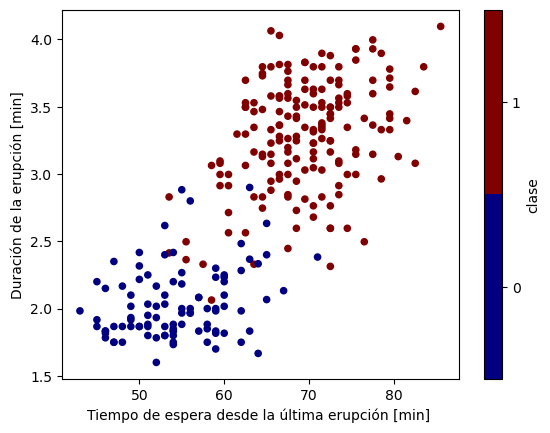

In [94]:
# Copio dataframe original
df_nls = df.copy()

# cambio valores de la clase positiva a mano (agrego un número aleatorio para evitar superposición de puntos)
df_nls.loc[df_nls.clase == 1, 'espera'] -= 10 + np.random.randn() * 0.5
df_nls.loc[df_nls.clase == 1, 'durac_erup'] -= 1 + np.random.randn() * 0.01

#plot
plot_data(df_nls)

In [95]:
# Preprocesado idéntico
datos_nls = df_nls.copy()

# Separo target
clase = datos_nls.pop('clase').to_numpy()

# Normalizo
scaler = StandardScaler()
datos_nlsn = scaler.fit_transform(datos_nls)

Ahora ajustemos el regresor lineal no regularizado a los datos modificados.

In [96]:
lr.fit(datos_nlsn, clase)

print('Parámetros: {}'.format(np.concatenate([lr.intercept_, lr.coef_[0]])))

Parámetros: [2.57911138 4.30288255 1.50882414]


<AxesSubplot:xlabel='Activación', ylabel='$p(C_1 | datos)$'>

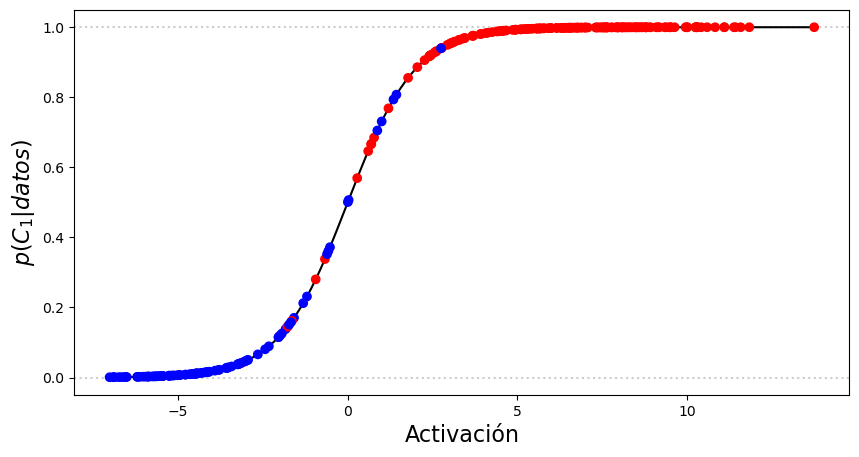

In [97]:
plot_proba(lr, datos_nlsn, clase)

Vemos que a pesar de no tener regularización, el modelo no se sobreajusta.

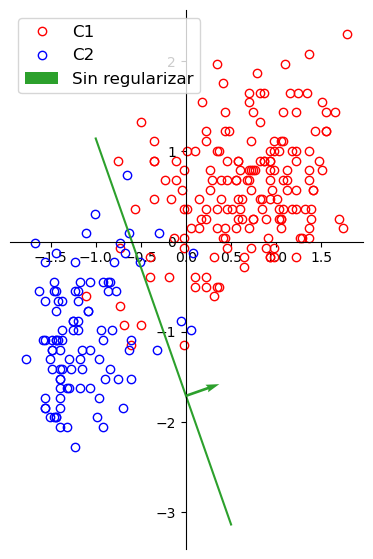

In [98]:
w_lr_nls = makew(lr)
plot_clasi(datos_nlsn, clase, ws=[w_lr_nls,], xp=[-1, 0.5], labels=['Sin regularizar'], equal=True)

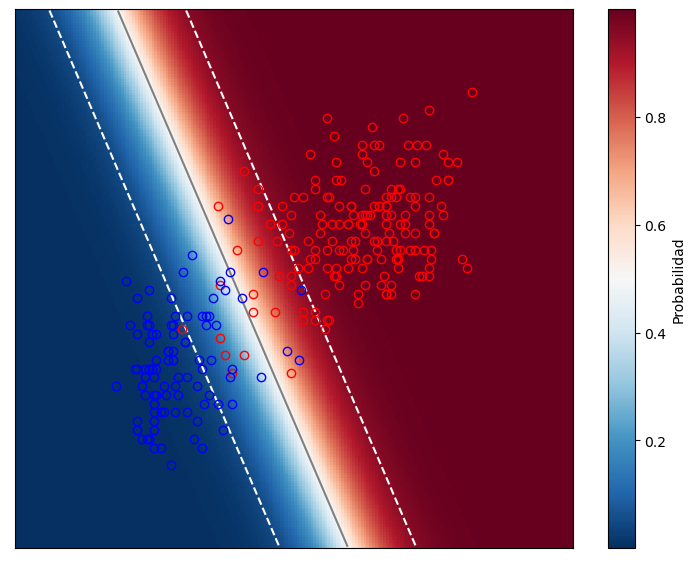

In [99]:
plot_fundec(lr, datos_nlsn, clase)

## Métricas

En un caso no linealmente separable, tener métricas para evaluar el algoritmo se vuelve especialmente importante.

Para decidir cuán bien nuestro clasificador funciona, necesitamos definir alguna métrica. Las siguientes son opciones comunes:

* Exactitud (accuracy): ¿Qué fracción de los puntos están clasificados correctamente?
* Precisión: ¿Cuántos puntos de los que predecimos que pertenecen a la Clase 1, realmente son de esa clase? Por supuesto, podemos también definir la precisión para la Clase 2 de manera análoga.
* Exhaustividad (recall): ¿Qué fracción de los puntos de la Clase 1 son clasificados como Clase 1?

Dependiendo de qué nos interese más, y cuán balanceado esté nuestro dataset (balance entre una clase y otra) eligiremos una u otra métrica. En el caso en el que estamos interesados en la precisión Y la exhaustividad, podemos considerar la media armónica de ambas:

* score F1: media armónica de la precisión y la exhaustividad.

Esta forma de calcular la media le da más peso al menor valor, de manera que un score F1 alto significa que tanto la precisión como la exhaustividad son altas.

Todas estas métricas se pueden calcular a partir de la *matriz de confusión*:

|  | Predicción C2 (-) | Predicción C1 (+) |
| --- | --- | --- |
| **Etiqueta C2 (-)** | Verdaderos Negativos (VN)  | Falsos Positivos (FP) |
| **Etiqueta C1 (+)** | Falsos Negativos (FN) | Verdaderos Positvos (VP) |

$$\text{Exactitud} = \frac{VP + VN}{VP+VN+FP+FN}$$
$$\text{Precisión} = \frac{VP}{VP+FP}$$
$$\text{Exhaustividad} = \frac{VP}{VP+FN}$$

Como se puede ver, para poder calcular estas métricas, necesitamos calcular las predicciones del modelo.

Por ahora, usemos el método `predict` sin preguntarnos más qué está pasando.

In [100]:
preds = lr.predict(datos_nlsn)

Por supuesto, todo esto está implementado en `sklearn`, en el paquete `metrics`.

In [101]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

print(f"Exactitud: {round(accuracy_score(clase, preds), 2)}")
print(f"Precisión: {round(precision_score(clase, preds), 2)}")
print(f"Exhaustividad: {round(recall_score(clase, preds), 2)}")
print("Matriz de confusión:")
print(confusion_matrix(clase, preds))

Exactitud: 0.95
Precisión: 0.96
Exhaustividad: 0.97
Matriz de confusión:
[[ 90   7]
 [  6 169]]


## Abrimos el capot

Cuando llamamos al método `predict` del regresor logístico, bajo el capó, `sklearn` calcula las probabilidades de cada conjunto de datos (pueden hacer esto mismo con el método `predict_proba`), y establece el **umbral** en 0,5.

* Abajo escribimos un código que produce las mismas predicciones que el método `predict` utilizando `predict_proba`.

In [106]:
# Definimos con qué clasificador trabajamos
clasificador = lr

# Calcula las probas
probas = clasificador.predict_proba(datos_nlsn)

# print
print(probas[:5])

# Vemos que suman 1
# print(np.sum(probas[:5], axis=1))

# Y vemos que hay un par para cada instancia
# print(probas.shape)

[[1.44519711e-01 8.55480289e-01]
 [9.95773479e-01 4.22652112e-03]
 [6.61736020e-01 3.38263980e-01]
 [7.68664619e-01 2.31335381e-01]
 [2.08061580e-04 9.99791938e-01]]
[1. 1. 1. 1. 1.]
(272, 2)


Para cada instancia, tenemos dos valores: la proba de pertenecer a la clase 1 y la de pertenecer a la clase 2. 

Ahora fijamos el umbral en 0.5, y clasificamos según si la proba de la clase 2 es mayor o menor que este valor

In [112]:
umbral = 0.5
pred_a_mano = np.where(probas[:, 1] >= umbral, 1, 0)

Finalmente verificamos el resultado usando `np.allclose` que comprueba que dos arrays son iguales elemento a elemento.

In [113]:
pred_con_predict = clasificador.predict(datos_nlsn)


print('Ambos métodos arrojan el mismo resultado: {}'.format(np.allclose(pred_a_mano, pred_con_predict)))

Ambos métodos arrojan el mismo resultado: True


La ventaja de esto es que ahora se puede cambiar el umbral utilizado para establecer las etiquetas.

En la celda de abajo
1. elegimos tres valores diferentes para el umbral.
2. hacemos predicciones con cada una de ellas
3. calculamos las métricas para las diferentes opciones de umbral.

In [118]:
from sklearn import metrics as m

probas = clasificador.predict_proba(datos_nlsn)

umbrales = [0.05, 0.5, 0.95]

for umbral in umbrales:
    y1 = np.where(probas[:, 1] >= umbral, 1, 0)

    print('Umbral {}'.format(umbral))
    print('----')
    print('Exactitud: {:.3f}'.format(m.accuracy_score(clase, y1)))
    print('Precisión: {:.3f}'.format(m.precision_score(clase, y1)))
    print('Exhaustividad: {:.3f}'.format(m.recall_score(clase, y1)))
    print('f1 score: {:.3f}'.format(m.f1_score(clase, y1)))
    print('####')

    print('Matriz de confusión')
    print(m.confusion_matrix(clase, y1))

    

Umbral 0.05
----
Exactitud: 0.908
Precisión: 0.879
Exhaustividad: 0.994
f1 score: 0.933
####
Matriz de confusión
[[ 73  24]
 [  1 174]]
Umbral 0.5
----
Exactitud: 0.952
Precisión: 0.960
Exhaustividad: 0.966
f1 score: 0.963
####
Matriz de confusión
[[ 90   7]
 [  6 169]]
Umbral 0.95
----
Exactitud: 0.904
Precisión: 1.000
Exhaustividad: 0.851
f1 score: 0.920
####
Matriz de confusión
[[ 97   0]
 [ 26 149]]


Ahora bien, todo esto se hace con el conjunto de datos de entrenamiento. Pero esto no es del todo correcto. Deberíamos utilizar las funciones del módulo `model_selection`: `cross_val_predict` y `cross_val_score`.

Abajo
1. Realizamos el mismo cálculo que el anterior pero validando de forma cruzada las predicciones. **Nota**: `cross_val_predict` por defecto usa el método `predict` de la clase en cuestión, pero acá queremos usar `predict_proba`. Hay que fijar esto con el argumento `method`.
2. Calculamos la matriz de confusión de validación cruzada. ¿Cómo puede hacerse esto?

In [117]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# Calculamos las predicciones con CV
probas = cross_val_predict(clasificador, datos_nlsn, clase, 
                           cv=5, method='predict_proba')

thrs = [0.05, 0.5, 0.95]

for thr in thrs:
    y1 = np.where(probas[:, 1] >= thr, 1, 0)

    print('Umbral {}'.format(thr))
    print('----')
    print('Exactitud: {:.3f}'.format(m.accuracy_score(clase, y1)))
    print('Precisión: {:.3f}'.format(m.precision_score(clase, y1)))
    print('Exhaustividad: {:.3f}'.format(m.recall_score(clase, y1)))
    print('f1 score: {:.3f}'.format(m.f1_score(clase, y1)))
    print('####')

    print('Matriz de confusión')
    print(m.confusion_matrix(clase, y1))




Umbral 0.05
----
Exactitud: 0.901
Precisión: 0.870
Exhaustividad: 0.994
f1 score: 0.928
####
Matriz de confusión
[[ 71  26]
 [  1 174]]
Umbral 0.5
----
Exactitud: 0.945
Precisión: 0.960
Exhaustividad: 0.954
f1 score: 0.957
####
Matriz de confusión
[[ 90   7]
 [  8 167]]
Umbral 0.95
----
Exactitud: 0.908
Precisión: 1.000
Exhaustividad: 0.857
f1 score: 0.923
####
Matriz de confusión
[[ 97   0]
 [ 25 150]]
